## Ice Sheet Surface Modeling 
In order to estimate thinning rates of the Laurentide Ice Sheet in New Hampshire at the end of the Last Glacial Maximum, a modeled ice sheet profile equation (Eq.1) can be used to generate three-dimensional ice sheet surfaces.  By interpolating between transects of modeled ice profiles anchored to dated ice recessional features (i.e. moraines), ice surfaces can be generated to reconstruct regional ice thinning through time (Fig.1).  This example will use MUQ's Gaussian Process capabilities to perform such an interpolation.

The input data for this example uses three modeled ice sheet profiles generated from 14.2 ka dated ice marginal feautures.  The data contains UTM coordinates as well as the modeled ice sheet thickness at each coordinate.  Using the example input data provided, an ice sheet surface can be interpolated between the profiles using Gaussian Processes.  




$$
H = \sqrt{\frac{2\tau L}{\rho g}} 
$$


Eq. 1: Modeled ice sheet profile equation (Nye, 1952); where $H$ is the thickness of the ice sheet at distance $L$ from the ice sheet margin, $g$ is gravity (9.8 $m/s^2$), $\rho$ is the density of glacial ice (900 $kg/m^3$), and $\tau$ is the basal shear stress acting upon the glacier (100 $kPa$).

![caption](14.2contours.jpg)
Figure 1: Surface reconstruction of the Laurentide Ice Sheet in New Hampshire over basal topography using 14.2 ka dated ice marginal features.  Black lines indicate a 0.25 km increase in ice sheet thickness from south to north.  

## Sample Data Format
The data to generate ice sheet surfaces is in IceSheetProfiles.csv and contains 3 seperate transects which will be used to interpolate between. Each transect is composed of Lat/Long coordinate data and each coordinate has an ice sheet thickness value assigned to it.  In total there are 9 columns (Longitude, Latitude, and Thickness value for each transect) and 4503 rows of data.

## Step 1: 
Build the ReadData function

In [89]:
%%writefile Icesheet_Interpolation.cpp

#include <iostream>
#include <fstream>
#include <string>
#include <sstream>
#include <Eigen/Dense>

#include "MUQ/Approximation/GaussianProcesses/CovarianceKernels.h"
#include "MUQ/Approximation/GaussianProcesses/GaussianProcess.h"

using namespace muq::Approximation;
using namespace std;

// This function reads the csv data and stores the result in a matrix
Eigen::MatrixXd ReadData(std::string const& filename)
{
    Eigen::MatrixXd output;
            
    // resize the matrix
    int numRows = 1000;
    int numCols = 3*3; // # transects * [x,y,z]
    output.resize(numRows, numCols);
    
    // open the csv file
    ifstream fin(filename);
    
    string line, part;
    getline(fin, line);
    getline(fin, line);
    for( int i=0; i<numRows; i++)
    {
        getline(fin,line);
        stringstream lineStream(line);
        
        for(int j=0; j<numCols; ++j)
        {
            getline(lineStream, part, ',');
            output(i,j) = stod(part);
        }
    }
    fin.close();
    
    // loop 
    return output;
}


Overwriting Icesheet_Interpolation.cpp


## Step 2: 
Read in the data


In [90]:
%%writefile -a Icesheet_Interpolation.cpp

int main()
{
    std::string filename = "IceSheetProfiles.csv";
    
    // Read the data from the specified file
    Eigen::MatrixXd data;
    data = ReadData(filename);
    

Appending to Icesheet_Interpolation.cpp


## Step 3:
Define the kernel and use it to construct the prior

In [91]:
%%writefile -a Icesheet_Interpolation.cpp
    
    // Construct the Gaussian process....
    auto kernel = SquaredExpKernel(2, 2.0, 100000);
    
    // Create the GP
    ConstantMean mean(1);
    auto gp = ConstructGP(mean, kernel);
    

Appending to Icesheet_Interpolation.cpp


## Step 4: 
Parse the data into two new matrices; one containing all of the lat/long data (2 rows) and the other containing the ice sheet thickness values (1 row).

In [92]:
%%writefile -a Icesheet_Interpolation.cpp
    
    // resize the data into trainLocs and trainData
    Eigen::MatrixXd trainLocs;
        
    int numRows = 2;
    int numCols = 3*data.rows(); // 
    trainLocs.resize(numRows, numCols);
    
    Eigen::MatrixXd trainData(1,numCols);
    
    int k = 0;
    for(int i=0; i<data.rows(); i++)
    {
        for(int j=0; j<3; j++)
        {
            trainLocs(0,k) = data(i,3*j);
            trainLocs(1,k) = data(i,3*j+1);
            trainData(0,k) = data(i,3*j+2);
            k++;
        }
    }

    

Appending to Icesheet_Interpolation.cpp


## Step 5: 
Compute the posterior

In [93]:
%%writefile -a Icesheet_Interpolation.cpp
    
    gp.Fit(trainLocs,trainData);
    

Appending to Icesheet_Interpolation.cpp


## Step 6:
Define where to identify the posterior

In [94]:
%%writefile -a Icesheet_Interpolation.cpp
    
    Eigen::MatrixXd predLocs;
    
    double lonMin = trainLocs.row(0).minCoeff();    
    double latMin = trainLocs.row(1).minCoeff();
    double latMax = trainLocs.row(1).maxCoeff();
    double lonMax = trainLocs.row(0).maxCoeff();
    
    int numLon = 20; 
    int numLat = 20;
    
    predLocs.resize(numRows, numLon*numLat);
    
    k = 0;
    for(int i=0; i<numLon; i++)
    {
        for(int j=0; j<numLat; j++)
        {
            predLocs(0,k) = lonMin + i*((lonMax-lonMin)/numLon);
            predLocs(1,k) = latMin + j*((latMax-latMin)/numLat);
            k++;
        }
    }
    

Appending to Icesheet_Interpolation.cpp


## Step 7:
Identify the posterior at the defined locations

In [95]:
%%writefile -a Icesheet_Interpolation.cpp   
    
    auto preds = gp.Predict(predLocs);
    

Appending to Icesheet_Interpolation.cpp


## Step 8:
Output the predictions file into a .csv

In [96]:
%%writefile -a Icesheet_Interpolation.cpp

    std::string outputFile = "PredictedThickness.csv";
    std::ofstream fout(outputFile);
    for(int j=0; j<predLocs.cols(); j++)
        fout << predLocs(0,j) << ", " << predLocs(1,j) << ", " << preds.mean(j) << "\n";
    
    fout.close();
    
    return 0;
}

Appending to Icesheet_Interpolation.cpp


## Step 9:
Build and compile in C++

In [97]:
%%bash 
cd build; cmake ../; make; cd ../

-- Configuring done
-- Generating done
-- Build files have been written to: /Users/rdcrltsh/Documents/Repositories/muq-private/examples/gaussian_process_icesheet/build
Scanning dependencies of target Interpolation
[ 50%] Building CXX object CMakeFiles/Interpolation.dir/Icesheet_Interpolation.cpp.o
[100%] Linking CXX executable Interpolation
[100%] Built target Interpolation


MUQ_LIBRARIES = /Users/rdcrltsh/Installations/MUQ/lib/libmuqModelingCore.dylib
MUQ_LINK_LIBRARIES = /Users/rdcrltsh/Installations/MUQ/muq_external/lib/libboost_filesystem.dylib;/Users/rdcrltsh/Installations/MUQ/muq_external/lib/libboost_system.dylib;/Users/rdcrltsh/Installations/MUQ/muq_external/lib/libboost_timer.dylib;/Users/rdcrltsh/Installations/MUQ/muq_external/lib/libboost_chrono.dylib;/Users/rdcrltsh/Installations/MUQ/muq_external/lib/libboost_graph.dylib;/Users/rdcrltsh/Installations/MUQ/muq_external/lib/libboost_serialization.dylib;/Users/rdcrltsh/Installations/MUQ/muq_external/lib/libboost_regex.dylib;/Users/rdcrltsh/Installations/MUQ/muq_external/lib/libboost_wserialization.dylib;/Users/rdcrltsh/Installations/MUQ/muq_external/lib/libboost_math_tr1.dylib;/Users/rdcrltsh/Installations/MUQ/muq_external/lib/libboost_math_tr1f.dylib;/Users/rdcrltsh/Installations/MUQ/muq_external/lib/libboost_math_tr1l.dylib


In [98]:
%%bash 
export DYLD_LIBRARY_PATH=$DYLD_LIBRARY_PATH:/Users/rdcrltsh/Installations/MUQ/lib:/Users/rdcrltsh/Installations/MUQ/muq_external/lib
build/Interpolation

## Step 10:
Validate the results and export the data in a form that can be used in ArcGIS.

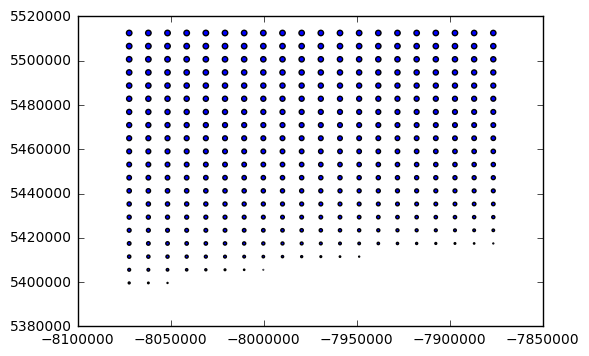

In [99]:
import pandas as pd
data = pd.read_csv('PredictedThickness.csv', header=None, names=['Longitude', 'Latitude', 'Thickness'])

import matplotlib.pyplot as plt
xData = data['Longitude']
yData = data['Latitude']
zData = data['Thickness']

plt.figure()
plt.scatter(xData, yData, s = 10*zData)
plt.show()